In [1]:
import pandas as pd
import cv2
import os
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

# import tensorflow as tf
import keras
import keras.backend as K
# from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.models.resnet import resnet_retinanet as retinanet, custom_objects, download_imagenet
# import keras_retinanet
import keras_retinanet.bin.train
from sklearn.utils import shuffle 
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [2]:
json_file = open('/home/jovyan/hico_model.json', 'r')
model_json = json_file.read()
json_file.close()
model = keras.models.model_from_json(model_json)
model.load_weights('/home/jovyan/hico_second_try.h5')

In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, None, 2, 4)   0           input_8[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 800, 1200, 3) 0                                            
__________

In [4]:
test_data = pd.read_json('../test_data_with_obj_id.json')
test_data = test_data.sort_index()
retinanet_test_data = pd.read_json('retinanet_test_data.json')
retinanet_test_data = retinanet_test_data.sort_index()

In [33]:
def data_gen(retinanet_test_data,test_data,id_):
    img_stack = np.array([]).reshape(0,800,1200,3)
    human_stack = np.array([]).reshape(0,4)
    object_stack = np.array([]).reshape(0,4)
    object_class_stack = np.array([]).reshape(1,0)
            #image
    img = cv2.imread(os.path.join('/home/jovyan/projectdata/cht01/hico_20160224_det/images/test2015/',test_data['name'][id_]))
    img = cv2.resize(img, (1200,800))
    img = img/255
    img = np.expand_dims(img,axis=0)
    img_stack = np.row_stack([img_stack,img])

            
            #human object bbox pair & object class
    for i in range(len(retinanet_test_data.human_boxes[id_])):
        if (np.max(retinanet_test_data.human_scores[id_]) >0.5) & (retinanet_test_data.human_scores[id_][i]<0.5):
            continue
        ho_pair_h = retinanet_test_data.human_boxes[id_][i]
        ho_pair_h = np.expand_dims(ho_pair_h,axis=0)
#         ho_pair_h = np.expand_dims(ho_pair_h,axis=0)
        human_stack = np.row_stack([human_stack,ho_pair_h])

    for j in range(len(retinanet_test_data.obj_boxes[id_])):
        if (np.max(retinanet_test_data.obj_scores[id_]) >0.5) & (retinanet_test_data.obj_scores[id_][j]<0.5):
            continue
#         print(j)
        ho_pair_o = retinanet_test_data.obj_boxes[id_][j]
        object_class = retinanet_test_data.obj_classes[id_][j]
        ho_pair_o = np.expand_dims(ho_pair_o,axis=0)
#       ho_pair_o = np.expand_dims(ho_pair_o,axis=0)

#       object_class = np.expand_dims(object_class,axis=0)
            
#       img_stack = np.row_stack([img_stack,img])
        object_stack = np.row_stack([object_stack,ho_pair_o])
        object_class_stack = np.column_stack([object_class_stack,object_class])
#     img_stack = np.expand_dims(img_stack,axis=0)
    human_stack = np.expand_dims(human_stack,axis=0)
    object_stack = np.expand_dims(object_stack,axis=0)
#     object_class_stack = np.expand_dims(object_class_stack,axis=0)
    test_batch = [img_stack,human_stack,object_stack,object_class_stack]
    return test_batch

In [34]:
# model_multigpu = keras.utils.multi_gpu_model(model,gpus=2)

In [35]:
test_one_img = data_gen(retinanet_test_data,test_data,6)

In [32]:
test_one_img[0].shape,test_one_img[1].shape,test_one_img[2].shape,test_one_img[3].shape

((1, 800, 1200, 3), (1, 4, 4), (1, 9, 4), (1, 9))

In [39]:
test_data.head(20)

,action_no,human_bbox,invisible,name,obj_id,obj_list,object_bbox,pair_no,size
0,[246],"[[320, 359, 306, 349], [270, 311, 303, 350]]",[0],HICO_test2015_00000001.jpg,[13],[bench],"[[148, 376, 345, 414]]","[[1, 1], [2, 1]]","[640, 427, 3]"
1,"[132, 140, 144]","[[226, 340, 18, 210], [230, 356, 19, 212], [23...","[0, 0, 0]",HICO_test2015_00000002.jpg,[17],[horse],"[[174, 393, 65, 440], [186, 392, 62, 438], [17...","[[1, 1], [1, 1], [1, 1]]","[640, 461, 3]"
2,[39],"[[302, 322, 182, 236]]",[0],HICO_test2015_00000003.jpg,[8],[boat],"[[234, 444, 85, 298]]","[[1, 1]]","[640, 425, 3]"
3,"[154, 155]","[[411, 481, 83, 186], [464, 547, 118, 221], [3...","[0, 0]",HICO_test2015_00000004.jpg,[3],[motorcycle],"[[338, 574, 109, 247], [110, 501, 183, 364], [...","[[1, 1], [2, 1], [3, 2], [4, 2], [1, 1], [2, 2]]","[640, 427, 1]"
4,"[209, 213]","[[5, 409, 62, 638], [2, 415, 60, 637]]","[0, 0]",HICO_test2015_00000005.jpg,[24],[backpack],"[[197, 466, 167, 638], [327, 470, 165, 524]]","[[1, 1], [1, 1]]","[480, 640, 3]"
5,[245],"[[31, 638, 114, 427]]",[0],HICO_test2015_00000006.jpg,[13],[bench],"[[28, 636, 213, 477]]","[[1, 1]]","[640, 480, 3]"
6,"[109, 110]","[[1, 108, 121, 414], [295, 470, 54, 281], [44,...","[0, 0]",HICO_test2015_00000007.jpg,[60],[dining_table],"[[16, 521, 247, 422], [2, 522, 239, 423]]","[[1, 1], [2, 1], [3, 1], [4, 1], [1, 1]]","[640, 426, 3]"
7,[160],"[[120, 247, 48, 235]]",[0],HICO_test2015_00000008.jpg,[3],[motorcycle],"[[347, 541, 106, 267], [118, 520, 72, 478]]","[[1, 1], [1, 2]]","[640, 480, 3]"
8,[265],"[[23, 393, 19, 626]]",[0],HICO_test2015_00000009.jpg,[55],[cake],"[[65, 334, 474, 627]]","[[1, 1]]","[426, 640, 3]"
9,[92],"[[99, 162, 71, 204], [1, 66, 62, 266], [288, 3...",[0],HICO_test2015_00000010.jpg,[56],[chair],"[[378, 398, 114, 131], [446, 475, 106, 169], [...","[[1, 1], [1, 2], [1, 3], [1, 4], [2, 1], [2, 2...","[480, 640, 3]"


In [44]:
test_data_list=retinanet_test_data.human_classes.tolist()

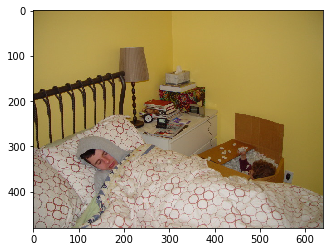

In [41]:
plt.imshow(cv2.imread(os.path.join('/home/jovyan/projectdata/cht01/hico_20160224_det/images/test2015/','HICO_test2015_00000020.jpg'))[:,:,::-1])

In [36]:
pred_all = []
for i in tqdm(range(test_data.shape[0])):
    test_one_img = data_gen(retinanet_test_data,test_data,i)
    pred = model.predict(test_one_img)
    pred_all.append(pred)

HBox(children=(IntProgress(value=0, max=9658), HTML(value='')))

InvalidArgumentError: Reshape cannot infer the missing input size for an empty tensor unless all specified input sizes are non-zero
	 [[Node: time_distributed_25/Reshape_1 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](time_distributed_25/Relu, time_distributed_25/Reshape_1/shape)]]
	 [[Node: lambda_8/while/while/Equal_2/_411 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1058_lambda_8/while/while/Equal_2", tensor_type=DT_BOOL, _device="/job:localhost/replica:0/task:0/device:CPU:0"](^_clooplambda_8/while/while/Assert_17/Assert/data_0/_157)]]

Caused by op 'time_distributed_25/Reshape_1', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-8d9e9c56cf10>", line 4, in <module>
    model = keras.models.model_from_json(model_json)
  File "/opt/conda/lib/python3.6/site-packages/keras/models.py", line 349, in model_from_json
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/opt/conda/lib/python3.6/site-packages/keras/layers/__init__.py", line 55, in deserialize
    printable_module_name='layer')
  File "/opt/conda/lib/python3.6/site-packages/keras/utils/generic_utils.py", line 143, in deserialize_keras_object
    list(custom_objects.items())))
  File "/opt/conda/lib/python3.6/site-packages/keras/engine/topology.py", line 2517, in from_config
    process_node(layer, node_data)
  File "/opt/conda/lib/python3.6/site-packages/keras/engine/topology.py", line 2474, in process_node
    layer(input_tensors[0], **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/keras/engine/topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/keras/layers/wrappers.py", line 208, in call
    y = K.reshape(y, (-1, input_length) + output_shape[2:])
  File "/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 1891, in reshape
    return tf.reshape(x, shape)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3938, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Reshape cannot infer the missing input size for an empty tensor unless all specified input sizes are non-zero
	 [[Node: time_distributed_25/Reshape_1 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](time_distributed_25/Relu, time_distributed_25/Reshape_1/shape)]]
	 [[Node: lambda_8/while/while/Equal_2/_411 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1058_lambda_8/while/while/Equal_2", tensor_type=DT_BOOL, _device="/job:localhost/replica:0/task:0/device:CPU:0"](^_clooplambda_8/while/while/Assert_17/Assert/data_0/_157)]]


In [ ]:

def bb_iou(boxA,boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	interArea = (xB - xA + 1) * (yB - yA + 1)
 
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	iou = interArea / float(boxAArea + boxBArea - interArea)
 	return iou

def compute_ap(gt_boxes, gt_class_ids,
               pred_boxes, pred_class_ids, pred_scores,
               iou_threshold=0.5):
    """Compute Average Precision at a set IoU threshold (default 0.5).

    Returns:
    mAP: Mean Average Precision
    precisions: List of precisions at different class score thresholds.
    recalls: List of recall values at different class score thresholds.
    overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Trim zero padding and sort predictions by score from high to low
    # TODO: cleaner to do zero unpadding upstream
#     gt_boxes = trim_zeros(gt_boxes)
#     pred_boxes = trim_zeros(pred_boxes)
#     pred_scores = pred_scores[:pred_boxes.shape[0]]
    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]

    # Compute IoU overlaps [pred_masks, gt_masks]
    overlaps = bb_iou(pred_boxes, gt_boxes)

    # Loop through ground truth boxes and find matching predictions
    match_count = 0
    pred_match = np.zeros([pred_boxes.shape[0]])
    gt_match = np.zeros([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        for j in sorted_ixs:
            # If ground truth box is already matched, go to next one
            if gt_match[j] == 1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            # Do we have a match?
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = 1
                pred_match[i] = 1
                break

    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match).astype(np.float32) / len(gt_match)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])

    return mAP, precisions, recalls, overlaps

In [ ]:
def mAP_test(pred_match,gt_match):
    precisions = np.cumsum(pred_match) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match).astype(np.float32) / len(gt_match)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])

    return mAP, precisions, recalls

In [ ]:
pred_match=[0,1,0,0,0,0,0,1,1]
gt_match=[1,1,1]
a,b,c = mAP_test(pred_match,gt_match)

In [ ]:
a

In [ ]:
b

In [ ]:
c